# TD3 trainer
this is the notebook I used for my research with TD3. full python/pytorch, no weird dependencies

In [ ]:
!python train.py

/bin/bash: /share/apps/anaconda3-2019.03-1/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/home/sh009885/.conda/envs/occ/lib/python3.8/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
env hypers set.
logdir is  ./log/20200521_cont/ 
running
env hypers set.
starting training loop...
/home/sh009885/code/rl-attitude-control/envs/ADCS_gym_cont.py:217: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  logger.warn("You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.")
mean cum. reward = -58.247256794567875, mean min ang = 66.110

In [9]:
import os
import math
import numpy as np
import json
import multiprocessing

import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR,CosineAnnealingLR
from tensorboardX import SummaryWriter

from envs.ADCS_gym_cont import AttitudeControlEnv

from IPython.display import clear_output

%load_ext tensorboard
clear_output()

In [10]:
if torch.cuda.is_available():
    device = 'cuda:0'
else:
    device = 'cpu'
    
# find GPU, number of cores available
num_cores = multiprocessing.cpu_count()
    
print(f'rolling on {torch.cuda.get_device_name(torch.cuda.current_device())}')
print(f'we have {num_cores} cores available')

rolling on Quadro RTX 5000
we have 48 cores available


In [11]:
logpath = './log/20200521_cont/'
runname = '20200515_run_3_rew7'

max_steps = 500

log_interval = 10           # print avg reward after interval
random_seed = 0
gamma = 0.99                # discount for future rewards
batch_size = 100            # num of transitions sampled from replay buffer
lr = 3e-4
exploration_noise = 0.1 
polyak = 0.995              # target policy update parameter (1-tau)
policy_noise = 0.2          # target policy smoothing noise
noise_clip = 0.5
policy_delay = 2            # delayed policy updates parameter
max_episodes = 10000         # max num of episodes

env = AttitudeControlEnv(torque_scale=0.5, steps=max_steps)

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
max_action = float(env.action_space.high[0])

#-----------------------------------------------------------
print('env hypers set.')

print(f'logdir is  {logpath} ')

os.makedirs(logpath, exist_ok=True)


env hypers set.
logdir is  ./log/20200521_cont/ 


/home/sh009885/.conda/envs/occ/lib/python3.8/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


In [12]:
import random
class PosEmbedding(nn.Module):
    def __init__(self, max_logscale, N_freqs, logscale=True):
        """
        Defines a function that embeds x to (sin(2^k x), cos(2^k x), ...)
        """
        super().__init__()
        self.funcs = [torch.sin, torch.cos]
        k = abs(np.random.normal(0,10,1)[0])
        if logscale:
            self.freqs = 2**torch.linspace(0, max_logscale, N_freqs)
        else:
            self.freqs = torch.linspace(1, 2**max_logscale, N_freqs)

    def forward(self, x):
        """
        Inputs:
            x: (B, 3)
        Outputs:
            out: (B, 6*N_freqs+3)
        """
        out = [x]
        for freq in self.freqs:
            for func in self.funcs:
                out += [func(freq*x)]
        return torch.cat(out, -1)        
        




class ReplayBuffer:
    def __init__(self, max_size=5e5):
        self.buffer = []
        self.max_size = int(max_size)
        self.size = 0
    
    def add(self, transition):
        self.size +=1
        # transiton is tuple of (state, action, reward, next_state, done)
        self.buffer.append(transition)
    
    def sample(self, batch_size):
        # delete 1/5th of the buffer when full
        if self.size > self.max_size:
            del self.buffer[0:int(self.size/5)]
            self.size = len(self.buffer)
        
        indexes = np.random.randint(0, len(self.buffer), size=batch_size)
        state, action, reward, next_state, done = [], [], [], [], []
        
        for i in indexes:
            s, a, r, s_, d = self.buffer[i]
            state.append(np.array(s, copy=False))
            action.append(np.array(a, copy=False))
            reward.append(np.array(r, copy=False))
            next_state.append(np.array(s_, copy=False))
            done.append(np.array(d, copy=False))
        
        return np.array(state), np.array(action), np.array(reward), np.array(next_state), np.array(done)


class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, max_action):
        super(Actor, self).__init__()
        
        self.l1 = nn.Linear(state_dim, 400)
        self.l2 = nn.Linear(400, 300)
        self.l3 = nn.Linear(300, action_dim)
        
        self.max_action = max_action
        
    def forward(self, state):
        a = F.relu(self.l1(state))
        a = F.relu(self.l2(a))
        a = torch.tanh(self.l3(a)) * self.max_action
        return a
        
class Critic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Critic, self).__init__()
        
        self.l1 = nn.Linear(state_dim + 21*action_dim, 400)
        self.l2 = nn.Linear(400, 300)
        self.l3 = nn.Linear(300, 1)
        
    def forward(self, state, action):
        state_action = torch.cat([state, action], 1)
        
        q = F.relu(self.l1(state_action))
        q = F.relu(self.l2(q))
        q = self.l3(q)
        return q
    
class TD3:
    def __init__(self, lr, state_dim, action_dim, max_action):
        self.embed = PosEmbedding(4,4)
        self.embed1 = PosEmbedding(4,10)
        self.actor = Actor(state_dim, action_dim, max_action).to(device)
        self.actor_target = Actor(state_dim, action_dim, max_action).to(device)
        self.actor_target.load_state_dict(self.actor.state_dict())
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=lr)
        self.actor_scheduler = StepLR(self.actor_optimizer, step_size=5e+5, gamma=0.5)
        
        self.critic_1 = Critic(state_dim, action_dim).to(device)
        self.critic_1_target = Critic(state_dim, action_dim).to(device)
        self.critic_1_target.load_state_dict(self.critic_1.state_dict())
        self.critic_1_optimizer = optim.Adam(self.critic_1.parameters(), lr=lr)
        self.critic_1_scheduler = StepLR(self.critic_1_optimizer, step_size=1e+6, gamma=0.5)
        
        self.critic_2 = Critic(state_dim, action_dim).to(device)
        self.critic_2_target = Critic(state_dim, action_dim).to(device)
        self.critic_2_target.load_state_dict(self.critic_2.state_dict())
        self.critic_2_optimizer = optim.Adam(self.critic_2.parameters(), lr=lr)
        self.critic_2_scheduler = StepLR(self.critic_2_optimizer, step_size=1e+6, gamma=0.5)
        
        self.max_action = max_action
    
    def select_action(self, state):
        state = torch.FloatTensor(state.reshape(1, -1)).to(device)
        return self.actor(self.embed(state)).cpu().data.numpy().flatten()
    
    def update(self, replay_buffer, n_iter, batch_size, gamma, polyak, policy_noise, noise_clip, policy_delay):
        
        for i in range(n_iter):
            # Sample a batch of transitions from replay buffer:
            # this is the "transition tuple" like sarsa but just SARS'
            state, action_, reward, next_state, done = replay_buffer.sample(batch_size)
            state = torch.FloatTensor(state).to(device)
            action = torch.FloatTensor(action_).to(device)
            reward = torch.FloatTensor(reward).reshape((batch_size,1)).to(device)
            next_state = torch.FloatTensor(next_state).to(device)
            done = torch.FloatTensor(done).reshape((batch_size,1)).to(device)
            
            # Select next action according to target policy:
            state = self.embed(state)
            next_state = self.embed(next_state)
            noise = torch.FloatTensor(action_).data.normal_(0, policy_noise).to(device)
            noise = noise.clamp(-noise_clip, noise_clip)
            next_action = (self.actor_target(next_state) + noise)
            next_action = next_action.clamp(-self.max_action, self.max_action)
            
            # Compute target Q-value:
            target_Q1 = self.critic_1_target(next_state, self.embed1(next_action))
            target_Q2 = self.critic_2_target(next_state, self.embed1(next_action))
            target_Q = torch.min(target_Q1, target_Q2)
            target_Q = reward + ((1-done) * gamma * target_Q).detach()
            
            # Optimize Critic 1:
            current_Q1 = self.critic_1(state, self.embed1(action))
            loss_Q1 = F.mse_loss(current_Q1, target_Q)
            self.critic_1_optimizer.zero_grad()
            loss_Q1.backward()
            self.critic_1_optimizer.step()
            
            # Optimize Critic 2:
            current_Q2 = self.critic_2(state, self.embed1(action))
            loss_Q2 = F.mse_loss(current_Q2, target_Q)
            self.critic_2_optimizer.zero_grad()
            loss_Q2.backward()
            self.critic_2_optimizer.step()
            
            # Delayed policy updates:
            if i % policy_delay == 0:
                # Compute actor loss:
                actor_loss = -self.critic_1(state, self.embed1(self.actor(state))).mean()
                
                # Optimize the actor
                self.actor_optimizer.zero_grad()
                actor_loss.backward()
                self.actor_optimizer.step()
                
                # Polyak averaging update:
                for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
                    target_param.data.copy_( (polyak * target_param.data) + ((1-polyak) * param.data))
                
                for param, target_param in zip(self.critic_1.parameters(), self.critic_1_target.parameters()):
                    target_param.data.copy_( (polyak * target_param.data) + ((1-polyak) * param.data))
                
                for param, target_param in zip(self.critic_2.parameters(), self.critic_2_target.parameters()):
                    target_param.data.copy_( (polyak * target_param.data) + ((1-polyak) * param.data))


In [13]:
t = PosEmbedding(4,10)
l = torch.rand(64,6)
out = t(l)


In [14]:
def find_agent_status(num_tests, policy):
    # run for given num episodes, calc stats, using no-noise policy
    rewsum_list = []
    meanminang_list = []
    for _ in range(num_tests):
        
        done = False
        obs = env.reset()

        reward_list = []
        obs_list = []
        
        while not done:
            act = policy.select_action(obs)
            # action = action + np.random.normal(0, exploration_noise, size=env.action_space.shape[0])
            act = act.clip(env.action_space.low, env.action_space.high)
            obs, reward, done, _ = env.step(act)
            reward_list.append(reward)
            obs_list.append(obs)
        
        q4 = [i[0] for i in obs_list]
        q1 = [i[1] for i in obs_list]
        q2 = [i[2] for i in obs_list]
        q3 = [i[3] for i in obs_list]

        curr_minang = 2*np.arccos(np.max(q4))*(180/np.pi)
        curr_rew_sum = np.sum(reward_list)
        
        rewsum_list.append(curr_rew_sum)
        meanminang_list.append(curr_minang)
    
    mean_min_ang = np.mean(meanminang_list)
    mean_rew_sum = np.mean(rewsum_list)
    
    return mean_rew_sum, mean_min_ang


In [15]:
policy = TD3(lr, 9*state_dim, action_dim, max_action)

replay_buffer = ReplayBuffer()

# logging variables:
avg_reward = 0
ep_reward = 0
writer = SummaryWriter(logpath+runname)

In [ ]:
#-----------TRAIN LOOP-----------
print(f'starting training loop...')

iternum = 0
num_tests = 10
lognum = 0

for episode in range(1, max_episodes+1):
    
    iternum+= 1
    
    state = env.reset()
    
    for t in range(max_steps):
        # select action and add exploration noise:
        action = policy.select_action(state)
        action = action + np.random.normal(0, exploration_noise, size=env.action_space.shape[0])
        action = action.clip(env.action_space.low, env.action_space.high)

        # take action in env:
        next_state, reward, done, _ = env.step(action)
        replay_buffer.add((state, action, reward, next_state, float(done)))
        state = next_state

        avg_reward += reward
        ep_reward += reward

        # if episode is done then update policy:
        if done or t==(max_steps-1):
            policy.update(replay_buffer, t, batch_size, gamma, polyak, policy_noise, noise_clip, policy_delay)
            break

    # logging updates:
    ep_reward = 0

    # print avg reward every log interval:
    if episode % log_interval == 0:
        lognum += 1
        # not necessary for us here: I dont use it
        avg_reward = int(avg_reward / log_interval)
        
        mean_rew_sum, mean_min_ang = find_agent_status(num_tests, policy)
        
        writer.add_scalar(f"mean cumul. reward over {num_tests} episodes", mean_rew_sum, lognum)
        writer.add_scalar(f"mean min ang over {num_tests} episodes", mean_min_ang, lognum)
        
        print(f'mean cum. reward = {mean_rew_sum}, mean min ang = {mean_min_ang}')


starting training loop...
mean cum. reward = -161.6598279790127, mean min ang = 97.19961169246572
mean cum. reward = -285.06748573030893, mean min ang = 72.80459389405645
mean cum. reward = -337.04434977099623, mean min ang = 66.7154670147993
mean cum. reward = -311.4984983452006, mean min ang = 63.627563021441425


In [78]:
fname = '20200515_run3_cont_3.dat'
torch.save(policy.actor.state_dict(), fname)

In [79]:
fname = '20200515_run3_cont_critic1_3.dat'
torch.save(policy.critic_1.state_dict(), fname)

fname = '20200515_run3_cont_critic2_3.dat'
torch.save(policy.critic_2.state_dict(), fname)

In [80]:
policy.actor.load_state_dict(torch.load('20200515_run3_cont_3.dat'))

<All keys matched successfully>

In [85]:
done = False

obs = env.reset()

reward_list = []
obs_list = []

while not done:
    action = policy.select_action(obs)

    action = action# + np.random.normal(0, exploration_noise, size=env.action_space.shape[0])
    action = action.clip(env.action_space.low, env.action_space.high)

    # no noise--select optimal
    #action = action + np.random.normal(0, exploration_noise, size=env.action_space.shape[0])
    obs, reward, done, _ = env.step(action)
    orn = np.array([obs[1], obs[2], obs[3], obs[0]])
    reward_list.append(reward)
    obs_list.append(obs)

In [86]:
x = np.linspace(0, 500, len(obs_list))
q4 = [i[0] for i in obs_list]
q1 = [i[1] for i in obs_list]
q2 = [i[2] for i in obs_list]
q3 = [i[3] for i in obs_list]

w1 = [i[8] for i in obs_list]
w2 = [i[9] for i in obs_list]
w3 = [i[10] for i in obs_list]

In [87]:
import time
import plotly.graph_objects as go
import pandas as pd
import plotly.express as px

In [88]:
2*np.arccos(np.max(q4))*(180/np.pi)

0.0378171738049639

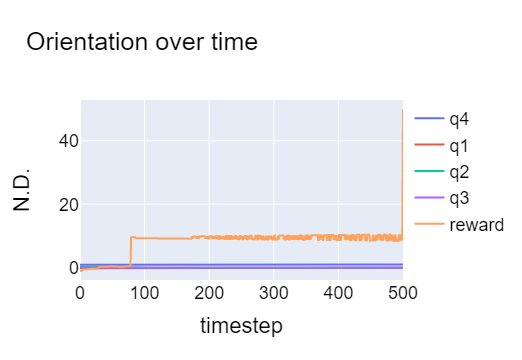

In [89]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=x, y=q4,
                    mode='lines',
                    name='q4'))
fig.add_trace(go.Scatter(x=x, y=q1,
                    mode='lines',
                    name='q1'))
fig.add_trace(go.Scatter(x=x, y=q2,
                    mode='lines',
                    name='q2'))
fig.add_trace(go.Scatter(x=x, y=q3,
                    mode='lines',
                    name='q3'))

fig.add_trace(go.Scatter(x=x, y=reward_list,
                    mode='lines',
                    name='reward'))


fig.update_layout(
    title="Orientation over time",
    xaxis_title="timestep",
    yaxis_title="N.D.",
    font=dict(
        family="Arial",
        size=18,
        color="#000000"
    )
)

fig.show()

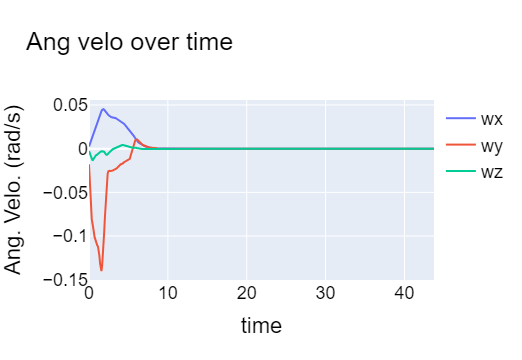

In [90]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=x/11.43, y=w1,
                    mode='lines',
                    name='wx'))
fig.add_trace(go.Scatter(x=x/11.43, y=w2,
                    mode='lines',
                    name='wy'))
fig.add_trace(go.Scatter(x=x/11.43, y=w3,
                    mode='lines',
                    name='wz'))

fig.update_layout(
    title="Ang velo over time",
    xaxis_title="time",
    yaxis_title="Ang. Velo. (rad/s)",
    font=dict(
        family="Arial",
        size=18,
        color="#000000"
    )
)

fig.show()

In [65]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'error quaternion')

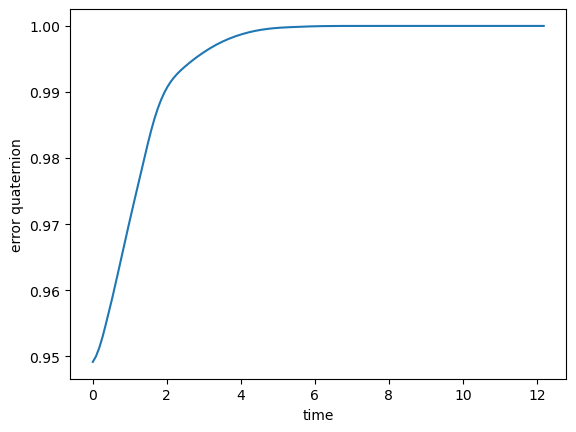

In [91]:
plt.plot(x[:140]/11.43,q4[:140])
plt.xlabel("time")
plt.ylabel("error quaternion")

Text(0, 0.5, 'angular error')

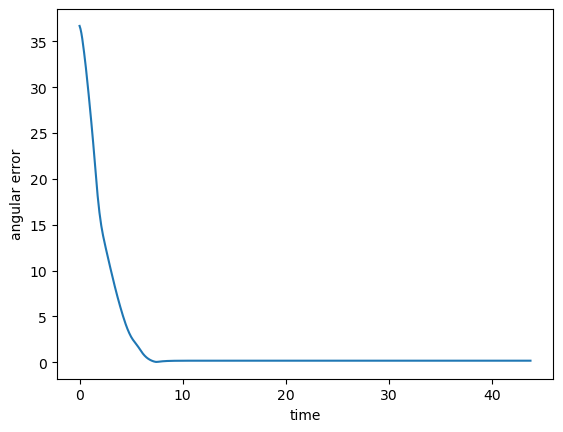

In [92]:
plt.plot(x/11.43,2*np.arccos(q4)*180/np.pi)
plt.xlabel("time")
plt.ylabel("angular error")

In [21]:
angle = np.array(q4)*180/np.pi

In [22]:
print(angle)

[31.74893622 31.82268397 31.93215586 32.074717   32.24510002 32.43476406
 32.6353061  32.8398514  33.04481554 33.24869393 33.45096156 33.65151569
 33.85039699 34.0476518  34.24345601 34.4379886  34.63140518 34.82387366
 35.01550901 35.20651222 35.39693806 35.58686266 35.77639211 35.96545539
 36.15396691 36.34192556 36.52927954 36.71624706 36.90298675 37.08964685
 37.27626542 37.46278364 37.64924609 37.8357821  38.02307754 38.21131553
 38.40036312 38.58997194 38.77998011 38.97027392 39.16076172 39.35167723
 39.54320581 39.73549184 39.92858341 40.12268204 40.31789244 40.51424956
 40.7117253  40.91027572 41.10985143 41.31024269 41.51128992 41.71287737
 41.91539437 42.11894948 42.32349439 42.52894755 42.73524961 42.94231595
 43.15006402 43.35827606 43.56654955 43.77450471 43.98174793 44.18791402
 44.39264664 44.59562621 44.79657679 44.99526632 45.19164204 45.38559716
 45.57697345 45.76568883 45.95169576 46.13510753 46.31598858 46.49436295
 46.67022714 46.84357063 47.01442542 47.18283783 47

In [9]:
rnn = nn.LSTM(10, 20, 2)
input = torch.randn(5, 3, 10)
h0 = torch.randn(2, 3, 20)
c0 = torch.randn(2, 3, 20)
output, (hn, cn) = rnn(input, (h0, c0))

In [11]:
output.shape

torch.Size([5, 3, 20])